In [1]:
import tensorflow as tf

tf.test.is_gpu_available()

True

In [2]:
pwd

'/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/vesicles'

In [4]:
%%time
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import vesicle

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

import pandas as pd

#########################################################################################################

# Configuration

# Dataset directory
# DATASET_DIR = '/allen/programs/braintv/workgroups/neuralcoding/Parastoo/EM_Data'
DATASET_DIR = '/allen/programs/braintv/workgroups/neuralcoding/Parastoo'
# DATASET_DIR = '/allen/programs/braintv/workgroups/neuralcoding/Parastoo/EM_Data'

# DATASET_DIR = '/src/'
# Inference Configuration
config = vesicle.NucleusInferenceConfig()
config.display()


#########################################################################################################
# Notebook preference

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"



def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

#########################################################################################################
# Load test dataset

dataset = vesicle.NucleusDataset()
# dataset.load_nucleus(DATASET_DIR, 'valid')
dataset.load_nucleus(DATASET_DIR, 'threeD_test')
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

#########################################################################################################
# Load model

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)
    

weights_path ='/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/vesicles/logs/vesicle20210215T1012/mask_rcnn_vesicle_0175.h5'
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)
print('************  Model is loaded  **************')


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1000
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [3]:
LOGS_DIR

'/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/logs'

## SAMPLE DETECTION TEST

5
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    1.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


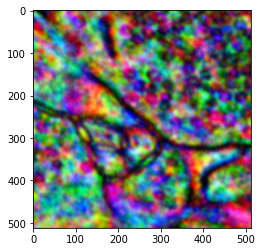

In [2]:
import timeit
import skimage


for image_id in dataset.image_ids[5:6]:
    print(image_id)
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    
plt.imshow(image)

results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

In [305]:
bad_recalls_ids = [4, 7, 8, 9, 16, 30, 32, 46]

0
The real image id =  250_046
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    1.00000  max:  254.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


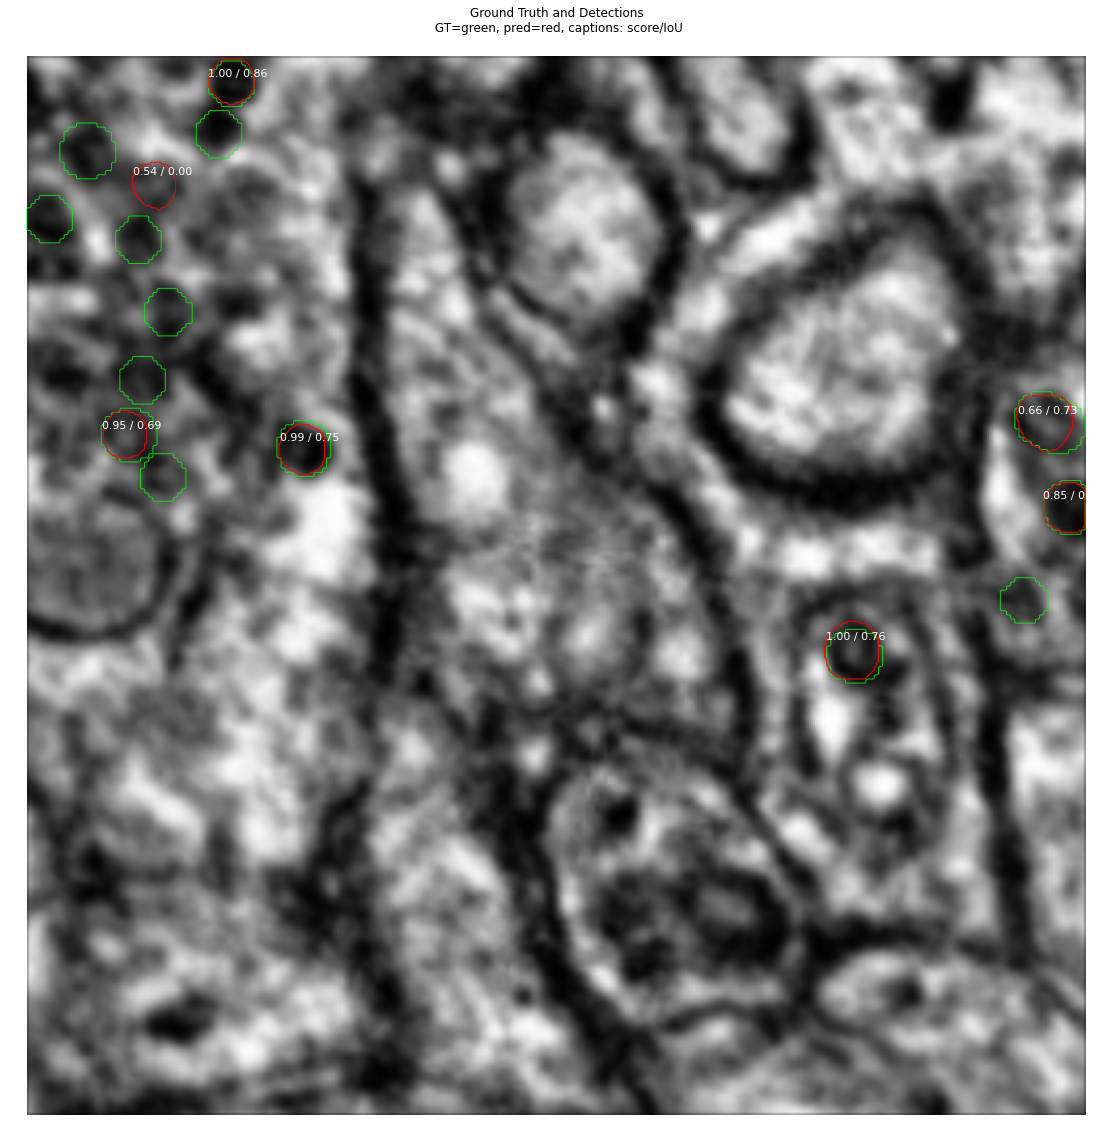

2.661970457993448


In [335]:
import timeit
import skimage
def run_detection(dataset):

#     for image_id in bad_recalls_ids:
    for image_id in dataset.image_ids[0:1]:
        print(image_id)
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
        info = dataset.image_info[image_id]
       
        print('The real image id = ', info['id'])
    # Run object detection
        results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

        # Display results
        r = results[0]

        # Get matches and overlaps
        gt_match, pred_match, overlaps = utils.compute_matches(
            gt_bbox, gt_class_id, gt_mask,
            r["rois"], r["class_ids"], r["scores"], r['masks'],
            iou_threshold=0.5)

        image = image[:, :, 1]
        image=image[:, :]
        image = skimage.color.gray2rgb(image)

        visualize.display_differences(
            image,
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            dataset.class_names, ax=get_ax(),
            show_box=False, show_mask=False,
            iou_threshold=0.5, score_threshold=0.5)
        plt.show()

execution_time = timeit.timeit("run_detection(dataset)", number=1, globals=globals())

print(execution_time)


In [44]:
info['id']

'250_021'

## MODEL PERFORMANCE

In [294]:
model_score_tb = pd.DataFrame(columns = ['image_id', 'scores','class_id','overlaps', 'TP', 'FP'])

In [295]:
val_error=[]
gt_num_ves = 0
for image_id in dataset.image_ids:
    print(image_id)
    try:
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
        info = dataset.image_info[image_id]
        print('***IMAGE_ID*** ', info['id'])
    #     print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
    #                                            dataset.image_reference(image_id)))
    #     print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

    # Run object detection
        results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

        # Display results
        r = results[0]
        log("gt_class_id", gt_class_id)
        log("gt_bbox", gt_bbox)
        log("gt_mask", gt_mask)

        # Get matches and overlaps
        gt_match, pred_match, overlaps = utils.compute_matches(
            gt_bbox, gt_class_id, gt_mask,
            r["rois"], r["class_ids"], r["scores"], r['masks'],
            iou_threshold=0.5)
        gt_num_ves += len(gt_match)

    #create model score table

        for i in range(len(pred_match)):
            model_score_tb.loc[len(model_score_tb), ['image_id', 'scores', 'class_id', 'overlaps', 'TP']] = dataset.image_info[image_id]['id'], r['scores'][i], r['class_ids'][i], np.max(overlaps), pred_match[i]

        # Compute AP over range 0.5 to 0.95 and print it
        utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                               r['rois'], r['class_ids'], r['scores'], r['masks'],
                               verbose=1)
    except ValueError:
        print('Value Error was raised again')
        val_error.append(image_id)

0
***IMAGE_ID***  250_046
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    1.00000  max:  254.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
gt_class_id              shape: (14,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (14, 4)               min:    0.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 14)        min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.418
AP @0.55:	 0.418
AP @0.60:	 0.418
AP @0.65:	 0.418
AP @0.70:	 0.418
AP @0.75:	 0.271
AP @0.80:	 0.138
AP @0.85:	 0.064
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.257
1
***IMAGE_ID***  250_045
Processing 1 images
image                    shape: (512, 512, 3)         m

In [300]:
model_score_tb

,image_id,scores,class_id,overlaps,TP,FP
0,250_046,0.99734,1,0.886266,1,0
1,250_046,0.99639,1,0.886266,1,0
2,250_046,0.955018,1,0.886266,1,0
3,250_046,0.795079,1,0.886266,1,0
4,250_046,0.769323,1,0.886266,1,0
...,...,...,...,...,...,...
899,250_021,0.807332,1,0.900726,1,0
900,250_021,0.76039,1,0.900726,0,1
901,250_021,0.715699,1,0.900726,1,0
902,250_021,0.708625,1,0.900726,1,0


In [301]:
rows = np.where(model_score_tb.class_id == 2)[0]
model_score_tb.drop(index=rows, inplace=True)

In [302]:
model_score_tb.loc[model_score_tb.TP > -1, ['TP', "FP"]] = 1 , 0
model_score_tb.loc[model_score_tb.TP == -1, ['TP', "FP"]] = 0 , 1
sorted_df  = model_score_tb.sort_values('scores', ascending=False)
precisions = np.cumsum(sorted_df.TP.values > 0) / (np.arange(len(sorted_df)) + 1)
precisions = np.concatenate([[0], precisions, [0]])
for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])
        

recalls = np.cumsum(sorted_df.TP.values > 0).astype(np.float32) / gt_num_ves
recalls = np.concatenate([[0], recalls, [1]])

indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
             precisions[indices])

sorted_df['precision'] = precisions[1:-1]
sorted_df['recall'] = recalls[1:-1]

In [303]:
mAP

0.7808939814567566

## ROC curve at epoch 78

Text(0.5, 0, 'recall')

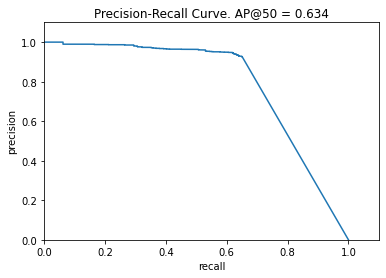

In [191]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 79

Text(0.5, 0, 'recall')

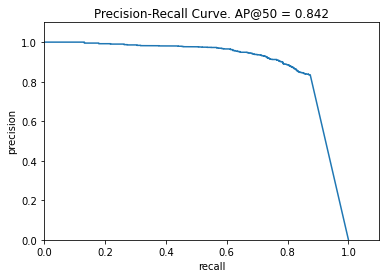

In [203]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 80

Text(0.5, 0, 'recall')

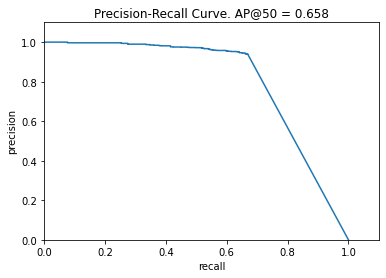

In [211]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 90

Text(0.5, 0, 'recall')

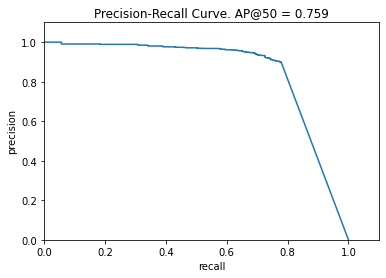

In [219]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 91

Text(0.5, 0, 'recall')

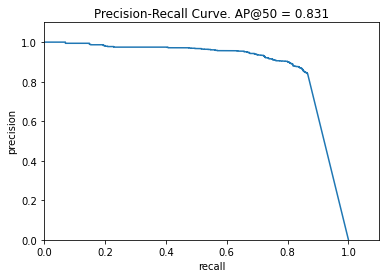

In [227]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC Curve at epoch 92

Text(0.5, 0, 'recall')

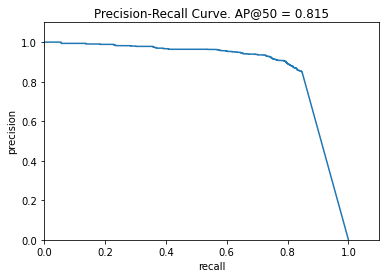

In [235]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 93

Text(0.5, 0, 'recall')

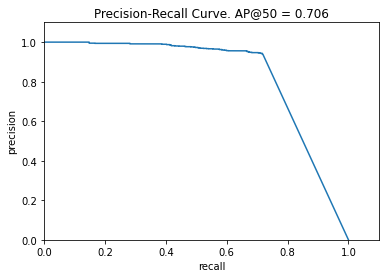

In [243]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 94

Text(0.5, 0, 'recall')

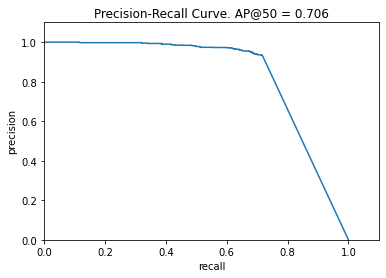

In [259]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 95

Text(0.5, 0, 'recall')

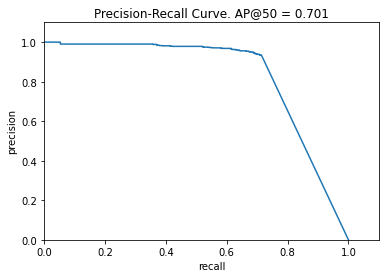

In [268]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 165

Text(0.5, 0, 'recall')

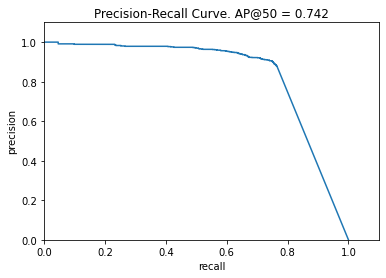

In [131]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 167

Text(0.5, 0, 'recall')

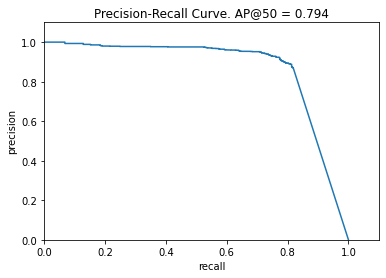

In [157]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 169

Text(0.5, 0, 'recall')

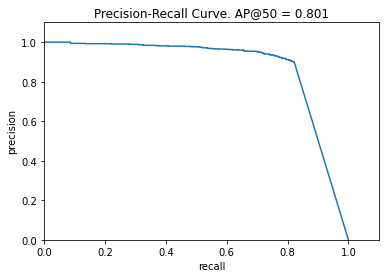

In [140]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 175

Text(0.5, 0, 'recall')

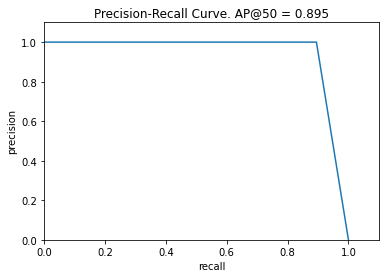

In [101]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 170

Text(0.5, 0, 'recall')

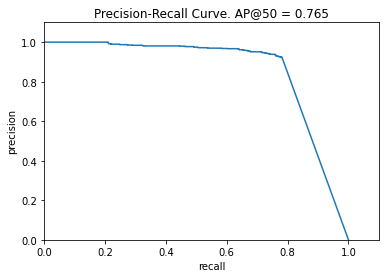

In [149]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## ROC curve at epoch 172

Text(0.5, 0, 'recall')

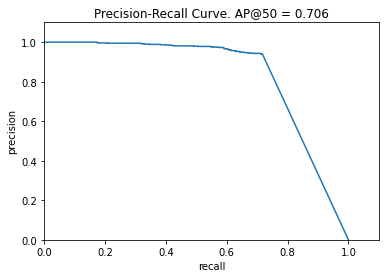

In [122]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

In [25]:
val_error

[2]

## Model ROC curve at epoch 10

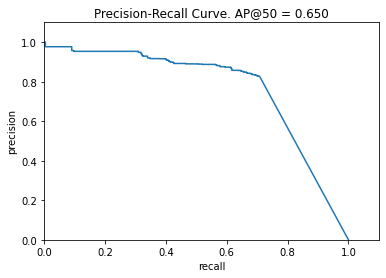

In [9]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## Model ROC curve at epoch 15

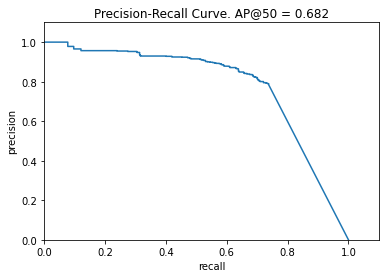

In [71]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## Model ROC curve at epoch 20

Text(0.5, 0, 'recall')

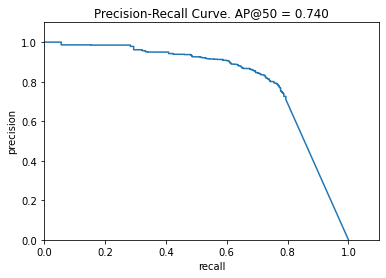

In [18]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
# plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## Model ROC curve at epoch 24

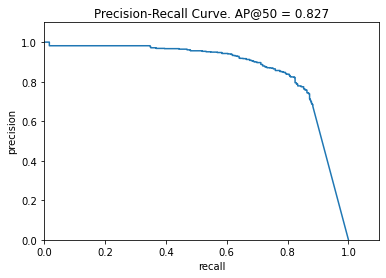

In [83]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## Model ROC curve at epoch 25

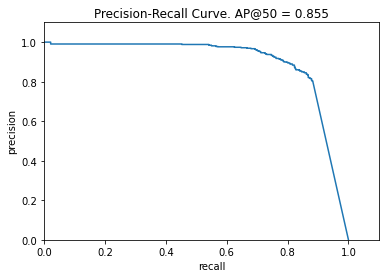

In [77]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## Model ROC curve at epoch 26

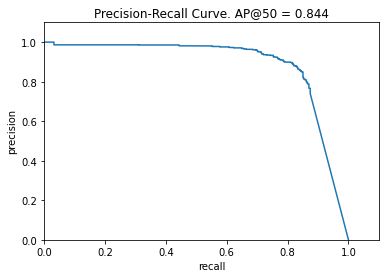

In [30]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## Model ROC curve at epoch 29

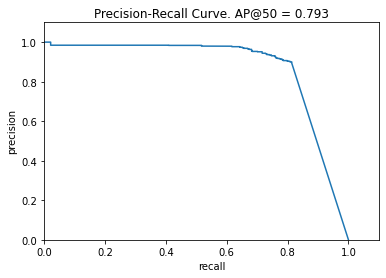

In [24]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

### Model ROC curve at epoch 30

Text(0.5, 0, 'recall')

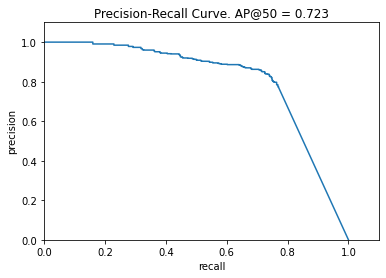

In [37]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
# plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## MODEL ROC curve at epoch 31

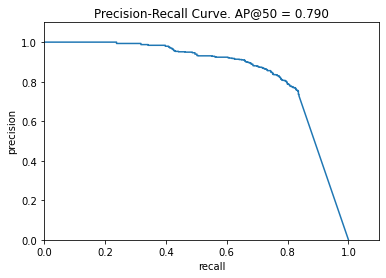

In [152]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## MODEL ROC curve at epoch 34

Text(0.5, 0, 'recall')

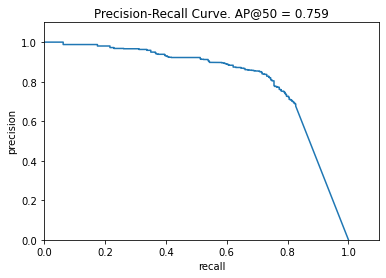

In [51]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
# plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## MODEL ROC curve at epoch 35

Text(0.5, 0, 'recall')

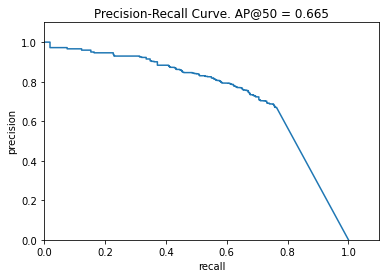

In [40]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
# plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## MODEL ROC curve at epoch 36

Text(0.5, 0, 'recall')

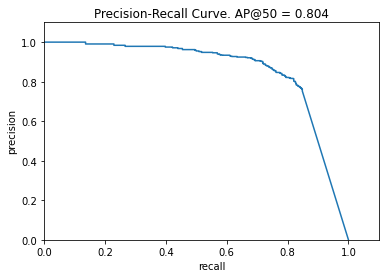

In [160]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## MODEL ROC curve at epoch 37

Text(0.5, 0, 'recall')

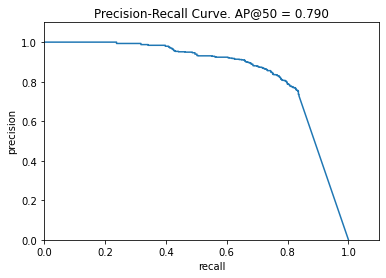

In [153]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## MODEL ROC curve at epoch 38

Text(0.5, 0, 'recall')

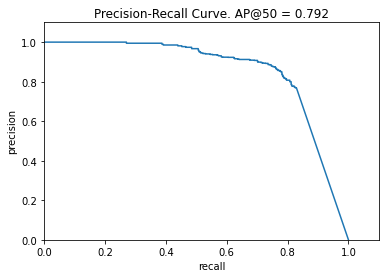

In [168]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## MODEL ROC curve at epoch 40

Text(0.5, 0, 'recall')

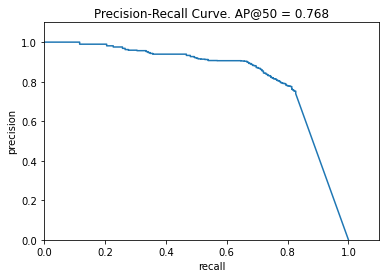

In [44]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
# plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

### Model ROC curve at epoch 45

Text(0.5, 0, 'recall')

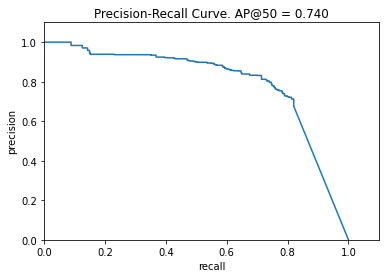

In [65]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
# plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

### Model ROC curve at epoch 50

Text(0.5, 0, 'recall')

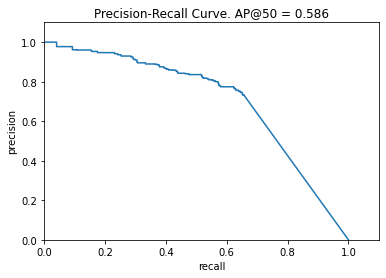

In [18]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
# plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## Model ROC curve at epoch 60

Text(0.5, 0, 'recall')

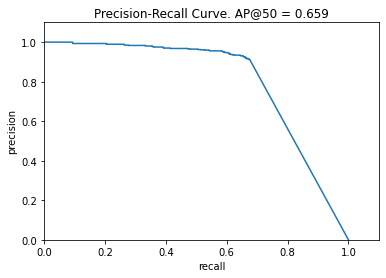

In [19]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
# plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## Model ROC curve at epoch 65

Text(0.5, 0, 'recall')

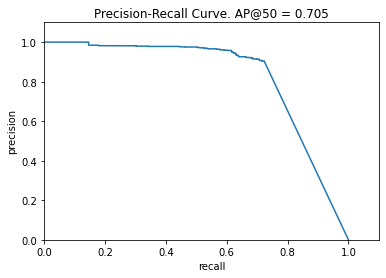

In [27]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 70

Text(0.5, 0, 'recall')

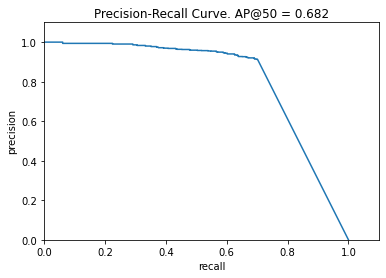

In [14]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
# plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## Model ROC curve at 73

Text(0.5, 0, 'recall')

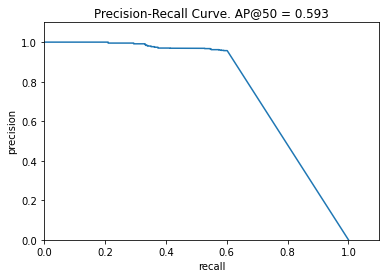

In [7]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at 74

Text(0.5, 0, 'recall')

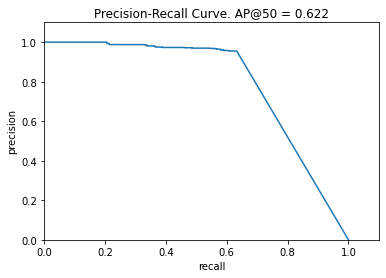

In [21]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

### Model ROC curve at epoch 75

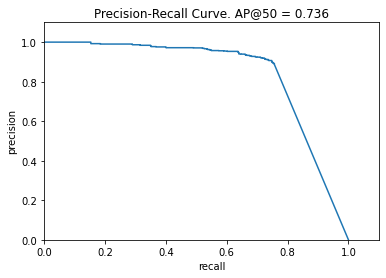

In [43]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
# plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

## Model ROC curve epoch 76

Text(0.5, 0, 'recall')

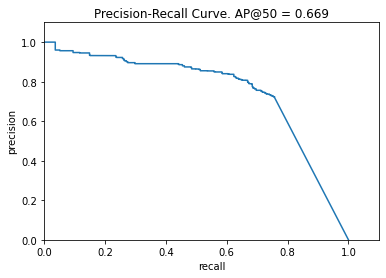

In [94]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 77

Text(0.5, 0, 'recall')

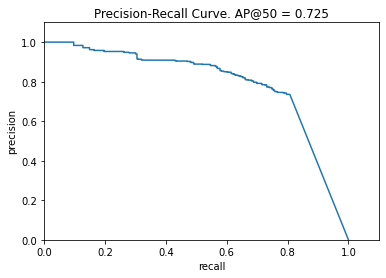

In [101]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 78

Text(0.5, 0, 'recall')

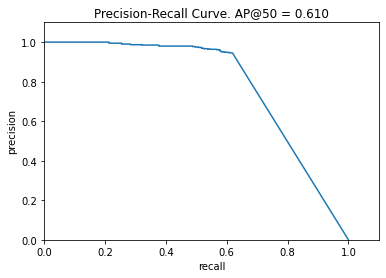

In [28]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 79

Text(0.5, 0, 'recall')

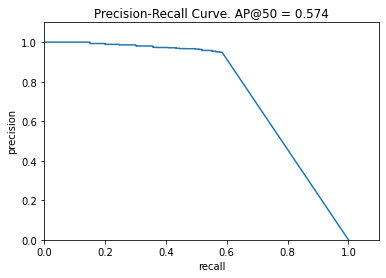

In [35]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at 80

Text(0.5, 0, 'recall')

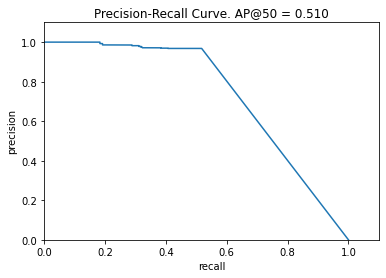

In [42]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at 81

Text(0.5, 0, 'recall')

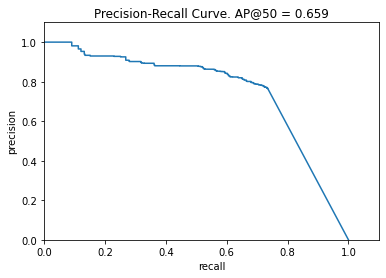

In [129]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 87

Text(0.5, 0, 'recall')

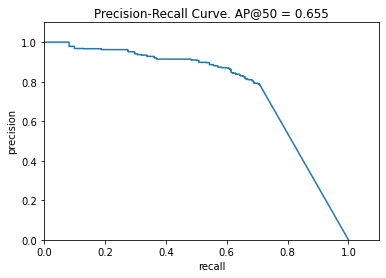

In [87]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

In [ ]:
## Model ROC curve at epoch 88

In [ ]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 89

Text(0.5, 0, 'recall')

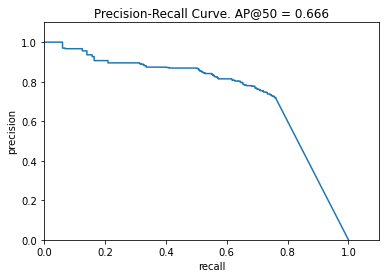

In [75]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 90

Text(0.5, 0, 'recall')

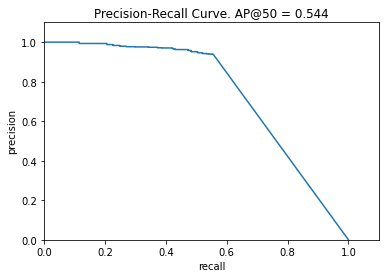

In [49]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 91

Text(0.5, 0, 'recall')

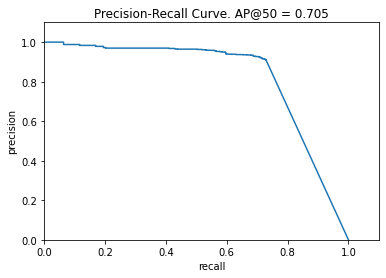

In [56]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 92

Text(0.5, 0, 'recall')

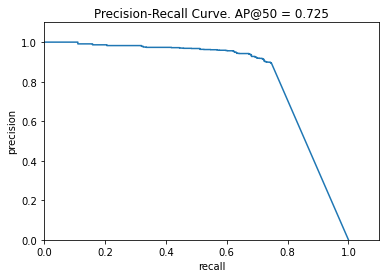

In [63]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 93

Text(0.5, 0, 'recall')

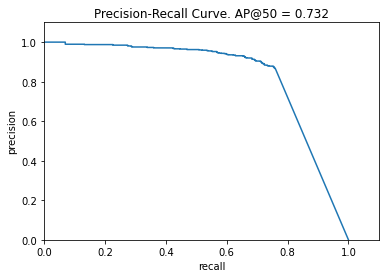

In [70]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 94

Text(0.5, 0, 'recall')

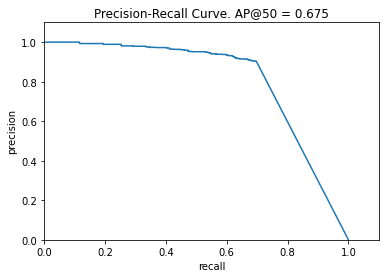

In [15]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 95

Text(0.5, 0, 'recall')

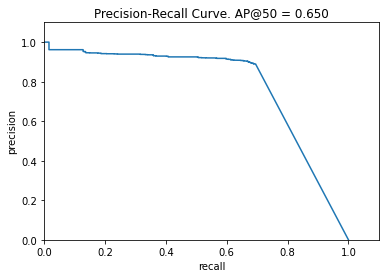

In [17]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 96

Text(0.5, 0, 'recall')

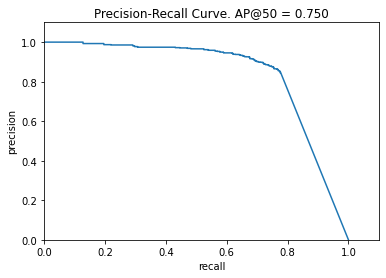

In [22]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 97

Text(0.5, 0, 'recall')

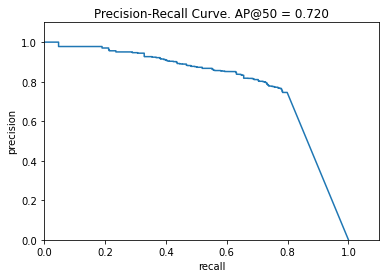

In [24]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 98

Text(0.5, 0, 'recall')

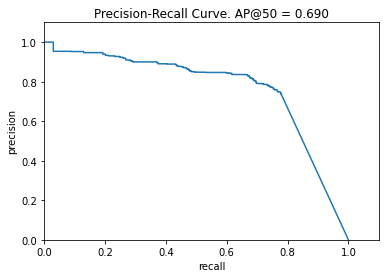

In [16]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

## Model ROC curve at epoch 99

Text(0.5, 0, 'recall')

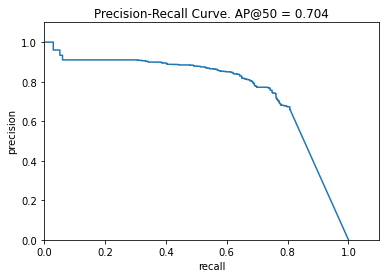

In [8]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')

### Model ROC curve at epoch 55

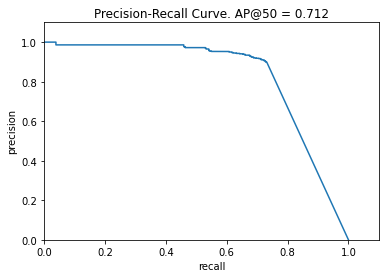

In [60]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

### Model ROC curve at epoch 60

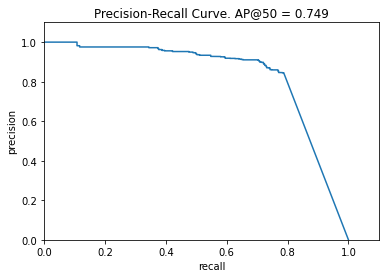

In [54]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

### Model ROC curve at epoch 100

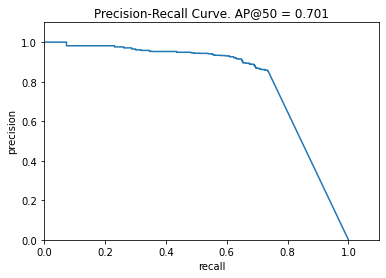

In [33]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

### Model ROC curve at epoch 150

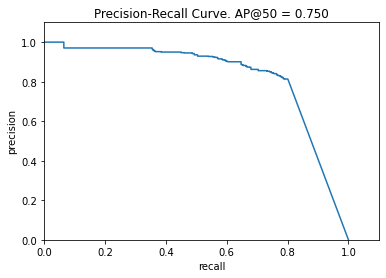

In [91]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

### Model ROC curve at epoch 200

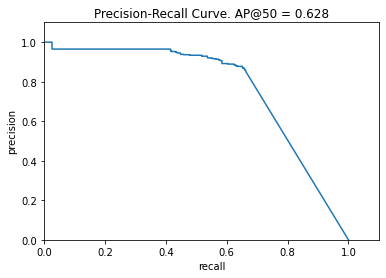

In [26]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')

### Model ROC curve at epoch 300

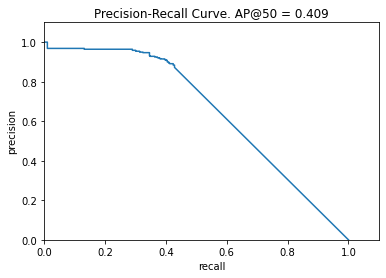

In [20]:
visualize.plot_precision_recall(mAP, precisions, recalls)
plt.ylabel('precision')
plt.xlabel('recall')
plt.savefig('/allen/programs/braintv/workgroups/neuralcoding/Parastoo/Mask_RCNN/samples/nucleus/ves_img/pr_curve.png')